# Dependency Loading

In [5]:
from transformers import pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from datasets import load_dataset
from datasets import Dataset
import datasets as ds
from datasets import DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Data Preparation

In [6]:
# https://huggingface.co/datasets/fhamborg/news_sentiment_newsmtsc
dataset_name = "fhamborg/news_sentiment_newsmtsc"

# Load dataset
dataset_sent = load_dataset(dataset_name)

# Define the columns to keep
columns_to_keep = ["polarity", "sentence"]

# Remove columns from each split
for split in dataset_sent.keys():
    dataset_sent[split] = dataset_sent[split].remove_columns(
        [col for col in dataset_sent[split].column_names if col not in columns_to_keep]
    )
# rename, so that datasets understands what is what
dataset_sent = dataset_sent.rename_columns({"polarity": "label", "sentence": "text"})

# rename because the models only support Z as numbers
df_train = pd.DataFrame(dataset_sent["train"])
df_test = pd.DataFrame(dataset_sent["test"])
df_val = pd.DataFrame(dataset_sent["validation"])

# Concatenate vertically
result_df = pd.concat([df_train, df_test, df_val], axis=0, ignore_index=True)

# Split into train (60%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(result_df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(temp_df, test_size=0.5, random_state=42)


# recreation the dataset dictionary
dataset_sent = ds.DatasetDict(
    {
        "train": Dataset.from_pandas(df_train),
        "test": Dataset.from_pandas(df_test),
        "validation": Dataset.from_pandas(df_val),
    }
)


# Creation of the test dataframe
test_dataset = pd.DataFrame(dataset_sent["test"])

# Model Loading

In [7]:
sentiment_pipeline_rogerkam = pipeline(model = "RogerKam/roberta_fine_tuned_sentiment_newsmtsc")

In [8]:
sentiment_pipeline_shashan = pipeline(model ="shashanksrinath/News_Sentiment_Analysis")

In [9]:
sentiment_pipeline_cardiffnlp = pipeline(model ="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
sentiment_pipeline_own_model = pipeline(
    model="MaxG1/roberta_fine_tuned_on_newsmstc_02_split"
)

c:\Users\Max_G\anaconda3\envs\ai_env\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Max_G\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# Let the testing and comparison beginn

In [11]:
for index, row in test_dataset.text.items():
  
    test_dataset.at[index, 'base_feeling_roger'] = int(sentiment_pipeline_rogerkam(row)[0]['label'][6:])

    test_dataset.at[index, 'base_feeling_shashan'] = sentiment_pipeline_shashan(row)[0]['label']

    test_dataset.at[index, 'base_feeling_cardiffnlp'] =  sentiment_pipeline_cardiffnlp(row)[0]['label']

    test_dataset.at[
        index, "base_feeling_own_model"
    ] = sentiment_pipeline_own_model(row)[0]["label"]
    


## Renaming the values, for the classifaction metrcis to work

In [12]:
test_dataset["base_feeling_own_model"].replace(
    {
        "negative": -1,
        "neutral": 0,
        "positive": 1,
    },
    inplace=True,
)

In [13]:
test_dataset['base_feeling_roger'].replace({
    0 : -1,
    1: 0,
    2: 1,  
}, inplace=True)

In [14]:
test_dataset['base_feeling_shashan'].replace({
    "Negative" : -1,
    "Neutral": 0,
    "Positive": 1,  
}, inplace=True)

In [15]:
test_dataset['base_feeling_cardiffnlp'].replace({
    "negative" : -1,
    "neutral": 0,
    "positive": 1,  
}, inplace=True)

## Checking the classifcation metrics to see how my model competes

### Metrcis for my own model

In [16]:
true_labels = test_dataset.label
predicted_labels = test_dataset.base_feeling_own_model

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average="weighted")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average="weighted")


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.83
Precision: 0.83
Recall: 0.83


### Metrcis for the model of roger kam


In [17]:
predicted_labels = test_dataset['base_feeling_roger']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Display the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Accuracy: 0.83
Precision: 0.83
Recall: 0.83


In [18]:

predicted_labels = test_dataset['base_feeling_shashan']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Display the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Accuracy: 0.49
Precision: 0.61
Recall: 0.49


In [19]:
predicted_labels = test_dataset['base_feeling_cardiffnlp']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Display the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Accuracy: 0.59
Precision: 0.69
Recall: 0.59


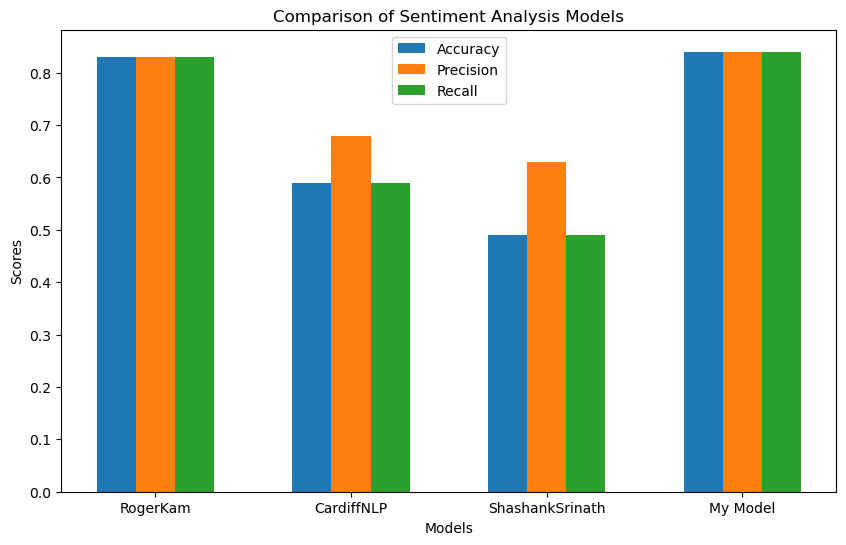

In [20]:
import matplotlib.pyplot as plt
import numpy as np

models = ["RogerKam", "CardiffNLP", "ShashankSrinath", "My Model"]
accuracy = [0.83, 0.59, 0.49, 0.84]
precision = [0.83, 0.68, 0.63, 0.84]
recall = [0.83, 0.59, 0.49, 0.84]

bar_width = 0.2
index = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, accuracy, bar_width, label="Accuracy")
bar2 = ax.bar(index + bar_width, precision, bar_width, label="Precision")
bar3 = ax.bar(index + 2 * bar_width, recall, bar_width, label="Recall")

ax.set_xlabel("Models")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Sentiment Analysis Models")
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models)
ax.legend()

plt.show()